### Blog post on low wage work and employment rates

January 23, 2019

Brian Dew, @bd_econ

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

# Get names of CBSAs
url = 'https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm'
cbsa_list = pd.read_html(url)[0]
cbsas = cbsa_list.set_index('CBSA Code')['CBSA Title'].to_dict()
# Fill in the gaps:
d = {14010: 'Bloomington, IL',
     15680: 'California-Lexington Park, MD',
     16060: 'Carbondale-Marion, IL',
     16540: 'Chambersburg-Waynesboro, PA',
     19300: 'Daphne-Fairhope-Foley, AL',
     20700: 'East Stroudsburg, PA',
     25940: 'Hilton Head Island-Bluffton-Beaufort, SC',
     27980: 'Kahului-Wailuku-Lahaina, HI',
     29200: 'Lafayette-West Lafayette, IN',
     31080: 'Los Angeles-Long Beach-Anaheim, CA',
     42200: 'Santa Maria-Santa Barbara, CA',
     46520: 'Urban Honolulu, HI',
     48060: 'Watertown-Fort Drum, NY'}

cbsa_dict = {**cbsas, **d}

# Save CBSA names 
pd.Series(cbsa_dict).to_csv('CBSA_Names.csv')

# Define various functions to apply to grouped data
def epop(group):
    """Calculate epop for group"""
    d = np.where(group['LFS'] == 'Employed', 1, 0)
    w = group['BASICWGT']
    return (d * w).sum() / w.sum() * 100.0

def p10wage(group):
    """Return BLS-styled binned first decile wage"""
    wage_var = 'RHRWAGE'
    weight = 'PWORWGT'
    group = group.query('PWORWGT > 0 and RHRWAGE > 0 and PRFTLF == 1')
    bin_size = 0.5 #($0.50)
    bins = list(np.arange(0.25, 300, bin_size))
    bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
    cum_sum = lambda x: x[weight].cumsum()
    dft = (group.sort_values(wage_var)
                .assign(WAGE_RANGE = bin_cut, CS = cum_sum))
    p10_point = dft[weight].sum() * 0.1
    p10_bin = (dft.iloc[(dft['CS'] - p10_point).abs().argsort()[:1]]
                  .WAGE_RANGE.values[0])
    wage_bins = list(dft['WAGE_RANGE'].unique())
    p10_loc = wage_bins.index(p10_bin)
    bin_below = dft[dft['WAGE_RANGE'] == wage_bins[p10_loc-1]].iloc[-1].CS
    bin_above = dft[dft['WAGE_RANGE'] == wage_bins[p10_loc]].iloc[-1].CS
    p10_value = ((((p10_point - bin_below) / 
                   (bin_above - bin_below)) * bin_size) + p10_bin.left)
    return p10_value

def unionmem(group):
    group = group.query('UNIONMEM in [0, 1]')
    member = group[group['UNIONMEM']==1]
    return member['PWORWGT'].sum() / group['PWORWGT'].sum() * 100.0

def unemp(group):
    group = group.query('LFS != "NILF"')
    unemp = group[group['LFS'] == 'Unemployed']
    return unemp['BASICWGT'].sum() / group['BASICWGT'].sum() * 100.0

def groupsize(group):
    group = group.query('PWORWGT > 0 and RHRWAGE > 0 and PRFTLF == 1')
    return len(group)

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [2]:
# Retrieve latest two years of CPS data
keep_cols = ['YEAR', 'MONTH', 'AGE', 'BASICWGT', 'LFS', 'UNIONMEM',
             'PRFTLF', 'PWORWGT', 'RHRWAGE', 'CBSA']
keep_rows1 = '25 <= AGE <= 54'
df2 = (pd.read_feather(f'cps2017.ft').filter(keep_cols).query(keep_rows1))
df2['MONTH'] = df2['MONTH'].astype('int8')
df3 = (pd.read_feather(f'cps2018.ft').filter(keep_cols).query(keep_rows1))
df4 = (pd.read_feather(f'cps2019.ft').filter(keep_cols).query(keep_rows1))

df = pd.concat([df2.query('MONTH > 8'), df3, df4])

In [3]:
# Apply calculations and save results
data = pd.DataFrame()
data['Count'] = df.groupby('CBSA').apply(groupsize)
data = data[data['Count'] > 300]
data['EPOP'] = df.groupby('CBSA').apply(epop)
data['P10wage'] = df.groupby('CBSA').apply(p10wage)
data['Union'] = df.groupby('CBSA').apply(unionmem)
data['Unemp'] = df.groupby('CBSA').apply(unemp)
data['Name'] = data.index.map(cbsa_dict)
data.to_csv('CBSA_2YR_Indicators.csv')

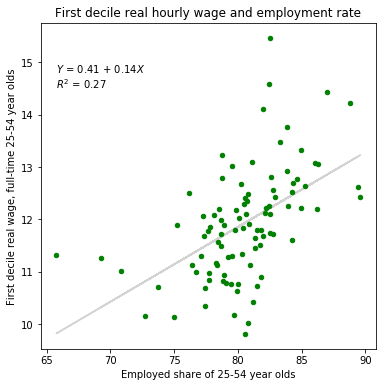

In [4]:
# Scatter plot of epop and first decile wage
y = data['P10wage']
x = data['EPOP']

r2 = np.corrcoef(x, y)[0, 1]**2
fit = np.polyfit(x, y, 1)

data.plot(kind='scatter', x='EPOP', y='P10wage', 
          zorder=2, color='green', figsize=(6, 6))
plt.plot(x, np.poly1d(fit)(x), color='lightgray', zorder=1)
text = f'$Y$ = {round(fit[1], 2)} + {round(fit[0], 2)}$X$\n$R^2$ = {round(r2, 2)}'
plt.text(x.min(), 14.5, text)
plt.title('First decile real hourly wage and employment rate')
plt.xlabel('Employed share of 25-54 year olds')
plt.ylabel('First decile real wage, full-time 25-54 year olds')
plt.savefig('CBSA_p10wage_epop.png')